In [52]:
# Data preparation for Ph.D thesis
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [53]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [54]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [55]:
# Paths
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=DATA_PATH # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
filename = 'timeseries_created_1574272163' # 'timeseries_created_1574259300' 'timeseries_created_157427216' 
FIELD = 'ts' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename+'.csv'])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename+'_indicators.csv'])

In [56]:
# Open file
df=pd.read_csv(file)
df['close'] = df[FIELD]
df['open'] = df[FIELD].shift(1) # close value of previous period/row
initial_len = len(df)
df.dropna(inplace=True) # remove first row as open is NaN
assert len(df) + 1 == initial_len
df['high'] = pd.np.maximum(df['open'], df['close'])
df['low'] = pd.np.minimum(df['open'], df['close'])
df = df[['open','close','high','low']]
df.head()

,open,close,high,low
1,227.503313,227.486627,227.503313,227.486627
2,227.486627,227.469943,227.486627,227.469943
3,227.469943,227.453259,227.469943,227.453259
4,227.453259,227.473630,227.473630,227.453259
5,227.473630,227.491800,227.491800,227.473630


In [57]:
#Add parameters to transform in TS
timeseries=['close']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4
1,227.503313,227.486627,227.503313,227.486627,NaN,NaN,NaN,NaN
2,227.486627,227.469943,227.486627,227.469943,227.486627,NaN,NaN,NaN
3,227.469943,227.453259,227.469943,227.453259,227.469943,227.486627,NaN,NaN
4,227.453259,227.473630,227.473630,227.453259,227.453259,227.469943,227.486627,NaN
5,227.473630,227.491800,227.491800,227.473630,227.473630,227.453259,227.469943,227.486627


In [58]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
1,227.503313,227.486627,227.503313,227.486627,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,227.494970,227.492189,227.490799,NaN,NaN,NaN,NaN,NaN,NaN
2,227.486627,227.469943,227.486627,227.469943,227.486627,NaN,NaN,NaN,NaN,NaN,...,NaN,227.478285,227.475504,227.474114,NaN,NaN,NaN,NaN,227.503313,NaN
3,227.469943,227.453259,227.469943,227.453259,227.469943,227.486627,NaN,NaN,NaN,NaN,...,NaN,227.461601,227.458820,227.457430,NaN,NaN,NaN,NaN,227.502646,NaN
4,227.453259,227.473630,227.473630,227.453259,227.453259,227.469943,227.486627,NaN,NaN,NaN,...,NaN,227.463444,227.466840,227.468537,NaN,NaN,NaN,NaN,227.500670,NaN
5,227.473630,227.491800,227.491800,227.473630,227.473630,227.453259,227.469943,227.486627,227.475052,NaN,...,NaN,227.482715,227.485743,227.487257,NaN,NaN,NaN,NaN,227.498774,NaN


In [59]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
# df = df[26000:]
df.dropna(inplace=True)
df.head()

,open,close,high,low,close_t-1,close_t-2,close_t-3,close_t-4,sma_5,sma_10,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
34,227.952418,227.966477,227.966477,227.952418,227.952418,227.935790,227.916834,227.899507,227.934205,227.893050,...,227.961790,227.962962,0.016413,0.110169,0.110777,-0.000609,227.884879,0.050657,227.981842,1
35,227.966477,227.981842,227.981842,227.966477,227.966477,227.952418,227.935790,227.916834,227.950672,227.909457,...,227.976720,227.978001,0.016308,0.109936,0.110609,-0.000673,227.901198,0.050579,228.000308,1
36,227.981842,228.000308,228.000308,227.981842,227.981842,227.966477,227.952418,227.935790,227.967367,227.926117,...,227.994153,227.995692,0.016524,0.109901,0.110467,-0.000567,227.917327,0.050561,228.018714,1
37,228.000308,228.018714,228.018714,228.000308,228.000308,227.981842,227.966477,227.952418,227.983952,227.942742,...,228.012579,228.014113,0.016712,0.110017,0.110377,-0.000360,227.933923,0.050633,228.033987,1
38,228.018714,228.033987,228.033987,228.018714,228.018714,228.000308,227.981842,227.966477,228.000266,227.959103,...,228.028896,228.030169,0.016568,0.110017,0.110305,-0.000289,227.950881,0.050680,228.048064,1


In [60]:
# df = df[41200:]


In [61]:
# Select columns for output
# columns_selected=[
#                  'rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']

# selection through grid search
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=';', encoding='utf-8', index = False)

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

Class distribution: 
0 in 0.6566065415263561%
1 in 0.34339345847364383%


<IPython.core.display.Javascript object>

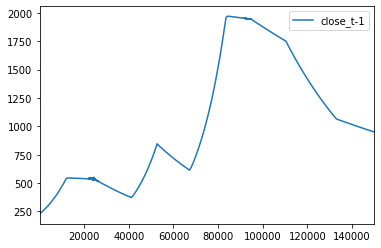

In [62]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.plot(y=["close_t-1"])
plt.show()